In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel



savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [10]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
"""From https://raw.githubusercontent.com/openai/guided-diffusion/main/guided_diffusion/unet.py."""
import math
from abc import abstractmethod

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F



"""Helpers to train with 16-bit precision."""

import numpy as np
import torch as th
import torch.nn as nn
from torch._utils import _flatten_dense_tensors, _unflatten_dense_tensors

"""Logger copied from OpenAI baselines to avoid extra RL-based dependencies:

https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/logger.py
"""

import datetime
import json
import os
import os.path as osp
import shutil
import sys
import tempfile
import time
import warnings
from collections import defaultdict
from contextlib import contextmanager

DEBUG = 10
INFO = 20
WARN = 30
ERROR = 40

DISABLED = 50

"""Various utilities for neural networks."""

import math

import torch as th
import torch.nn as nn


# PyTorch 1.7 has SiLU, but we support PyTorch 1.5.
class SiLU(nn.Module):
    def forward(self, x):
        return x * th.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def conv_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D convolution module."""
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """Create a linear module."""
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """Create a 1D, 2D, or 3D average pooling module."""
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def update_ema(target_params, source_params, rate=0.99):
    """Update target parameters to be closer to those of source parameters using an exponential
    moving average.

    :param target_params: the target parameter sequence.
    :param source_params: the source parameter sequence.
    :param rate: the EMA rate (closer to 1 means slower).
    """
    for targ, src in zip(target_params, source_params):
        targ.detach().mul_(rate).add_(src, alpha=1 - rate)




def zero_module(module, std=1e-3):
    """Initialize the parameters of a module with small Gaussian noise and return it."""
    for p in module.parameters():
        if p.dim() > 1:  # typically weights
            nn.init.normal_(p, mean=0.0, std=std)
        else:  # typically biases
            nn.init.zeros_(p)
    return module


def scale_module(module, scale):
    """Scale the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """Take the mean over all non-batch dimensions."""
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """Make a standard normalization layer.

    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = th.exp(
        -math.log(max_period)
        * th.arange(start=0, end=half, dtype=th.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = th.cat([th.cos(args), th.sin(args)], dim=-1)
    if dim % 2:
        embedding = th.cat([embedding, th.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def checkpoint(func, inputs, params, flag):
    """Evaluate a function without caching intermediate activations, allowing for reduced memory at
    the expense of extra compute in the backward pass.

    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(th.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with th.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with th.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = th.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads



class KVWriter:
    def writekvs(self, kvs):
        raise NotImplementedError


class SeqWriter:
    def writeseq(self, seq):
        raise NotImplementedError


class HumanOutputFormat(KVWriter, SeqWriter):
    def __init__(self, filename_or_file):
        if isinstance(filename_or_file, str):
            self.file = open(filename_or_file, "w")
            self.own_file = True
        else:
            assert hasattr(filename_or_file, "read"), (
                "expected file or str, got %s" % filename_or_file
            )
            self.file = filename_or_file
            self.own_file = False

    def writekvs(self, kvs):
        # Create strings for printing
        key2str = {}
        for key, val in sorted(kvs.items()):
            if hasattr(val, "__float__"):
                valstr = "%-8.3g" % val
            else:
                valstr = str(val)
            key2str[self._truncate(key)] = self._truncate(valstr)

        # Find max widths
        if len(key2str) == 0:
            print("WARNING: tried to write empty key-value dict")
            return
        else:
            keywidth = max(map(len, key2str.keys()))
            valwidth = max(map(len, key2str.values()))

        # Write out the data
        dashes = "-" * (keywidth + valwidth + 7)
        lines = [dashes]
        for key, val in sorted(key2str.items(), key=lambda kv: kv[0].lower()):
            lines.append(
                "| %s%s | %s%s |"
                % (key, " " * (keywidth - len(key)), val, " " * (valwidth - len(val)))
            )
        lines.append(dashes)
        self.file.write("\n".join(lines) + "\n")

        # Flush the output to the file
        self.file.flush()

    def _truncate(self, s):
        maxlen = 30
        return s[: maxlen - 3] + "..." if len(s) > maxlen else s

    def writeseq(self, seq):
        seq = list(seq)
        for i, elem in enumerate(seq):
            self.file.write(elem)
            if i < len(seq) - 1:  # add space unless this is the last one
                self.file.write(" ")
        self.file.write("\n")
        self.file.flush()

    def close(self):
        if self.own_file:
            self.file.close()


class JSONOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "w")

    def writekvs(self, kvs):
        for k, v in sorted(kvs.items()):
            if hasattr(v, "dtype"):
                kvs[k] = float(v)
        self.file.write(json.dumps(kvs) + "\n")
        self.file.flush()

    def close(self):
        self.file.close()


class CSVOutputFormat(KVWriter):
    def __init__(self, filename):
        self.file = open(filename, "w+t")
        self.keys = []
        self.sep = ","

    def writekvs(self, kvs):
        # Add our current row to the history
        extra_keys = list(kvs.keys() - self.keys)
        extra_keys.sort()
        if extra_keys:
            self.keys.extend(extra_keys)
            self.file.seek(0)
            lines = self.file.readlines()
            self.file.seek(0)
            for i, k in enumerate(self.keys):
                if i > 0:
                    self.file.write(",")
                self.file.write(k)
            self.file.write("\n")
            for line in lines[1:]:
                self.file.write(line[:-1])
                self.file.write(self.sep * len(extra_keys))
                self.file.write("\n")
        for i, k in enumerate(self.keys):
            if i > 0:
                self.file.write(",")
            v = kvs.get(k)
            if v is not None:
                self.file.write(str(v))
        self.file.write("\n")
        self.file.flush()

    def close(self):
        self.file.close()


class TensorBoardOutputFormat(KVWriter):
    """Dumps key/value pairs into TensorBoard's numeric format."""

    def __init__(self, dir):
        os.makedirs(dir, exist_ok=True)
        self.dir = dir
        self.step = 1
        prefix = "events"
        path = osp.join(osp.abspath(dir), prefix)
        import tensorflow as tf
        from tensorflow.core.util import event_pb2
        from tensorflow.python import pywrap_tensorflow
        from tensorflow.python.util import compat

        self.tf = tf
        self.event_pb2 = event_pb2
        self.pywrap_tensorflow = pywrap_tensorflow
        self.writer = pywrap_tensorflow.EventsWriter(compat.as_bytes(path))

    def writekvs(self, kvs):
        def summary_val(k, v):
            kwargs = {"tag": k, "simple_value": float(v)}
            return self.tf.Summary.Value(**kwargs)

        summary = self.tf.Summary(value=[summary_val(k, v) for k, v in kvs.items()])
        event = self.event_pb2.Event(wall_time=time.time(), summary=summary)
        event.step = self.step  # is there any reason why you'd want to specify the step?
        self.writer.WriteEvent(event)
        self.writer.Flush()
        self.step += 1

    def close(self):
        if self.writer:
            self.writer.Close()
            self.writer = None


def make_output_format(format, ev_dir, log_suffix=""):
    os.makedirs(ev_dir, exist_ok=True)
    if format == "stdout":
        return HumanOutputFormat(sys.stdout)
    elif format == "log":
        return HumanOutputFormat(osp.join(ev_dir, "log%s.txt" % log_suffix))
    elif format == "json":
        return JSONOutputFormat(osp.join(ev_dir, "progress%s.json" % log_suffix))
    elif format == "csv":
        return CSVOutputFormat(osp.join(ev_dir, "progress%s.csv" % log_suffix))
    elif format == "tensorboard":
        return TensorBoardOutputFormat(osp.join(ev_dir, "tb%s" % log_suffix))
    else:
        raise ValueError(f"Unknown format specified: {format}")


# ================================================================
# API
# ================================================================


def logkv(key, val):
    """Log a value of some diagnostic Call this once for each diagnostic quantity, each iteration
    If called many times, last value will be used."""
    get_current().logkv(key, val)


def logkv_mean(key, val):
    """The same as logkv(), but if called many times, values averaged."""
    get_current().logkv_mean(key, val)


def logkvs(d):
    """Log a dictionary of key-value pairs."""
    for k, v in d.items():
        logkv(k, v)


def dumpkvs():
    """Write all of the diagnostics from the current iteration."""
    return get_current().dumpkvs()


def getkvs():
    return get_current().name2val


def log(*args, level=INFO):
    """Write the sequence of args, with no separators, to the console and output files (if you've
    configured an output file)."""
    get_current().log(*args, level=level)


def debug(*args):
    log(*args, level=DEBUG)


def info(*args):
    log(*args, level=INFO)


def warn(*args):
    log(*args, level=WARN)


def error(*args):
    log(*args, level=ERROR)


def set_level(level):
    """Set logging threshold on current logger."""
    get_current().set_level(level)


def set_comm(comm):
    get_current().set_comm(comm)


def get_dir():
    """Get directory that log files are being written to.

    will be None if there is no output directory (i.e., if you didn't call start)
    """
    return get_current().get_dir()


record_tabular = logkv
dump_tabular = dumpkvs


@contextmanager
def profile_kv(scopename):
    logkey = "wait_" + scopename
    tstart = time.time()
    try:
        yield
    finally:
        get_current().name2val[logkey] += time.time() - tstart


def profile(n):
    """
    Usage:
    @profile("my_func")
    def my_func(): code
    """

    def decorator_with_name(func):
        def func_wrapper(*args, **kwargs):
            with profile_kv(n):
                return func(*args, **kwargs)

        return func_wrapper

    return decorator_with_name


# ================================================================
# Backend
# ================================================================


def get_current():
    if Logger.CURRENT is None:
        _configure_default_logger()

    return Logger.CURRENT


class Logger:
    DEFAULT = None  # A logger with no output files. (See right below class definition)
    # So that you can still log to the terminal without setting up any output files
    CURRENT = None  # Current logger being used by the free functions above

    def __init__(self, dir, output_formats, comm=None):
        self.name2val = defaultdict(float)  # values this iteration
        self.name2cnt = defaultdict(int)
        self.level = INFO
        self.dir = dir
        self.output_formats = output_formats
        self.comm = comm

    # Logging API, forwarded
    # ----------------------------------------
    def logkv(self, key, val):
        self.name2val[key] = val

    def logkv_mean(self, key, val):
        oldval, cnt = self.name2val[key], self.name2cnt[key]
        self.name2val[key] = oldval * cnt / (cnt + 1) + val / (cnt + 1)
        self.name2cnt[key] = cnt + 1

    def dumpkvs(self):
        if self.comm is None:
            d = self.name2val
        else:
            d = mpi_weighted_mean(
                self.comm,
                {name: (val, self.name2cnt.get(name, 1)) for (name, val) in self.name2val.items()},
            )
            if self.comm.rank != 0:
                d["dummy"] = 1  # so we don't get a warning about empty dict
        out = d.copy()  # Return the dict for unit testing purposes
        for fmt in self.output_formats:
            if isinstance(fmt, KVWriter):
                fmt.writekvs(d)
        self.name2val.clear()
        self.name2cnt.clear()
        return out

    def log(self, *args, level=INFO):
        if self.level <= level:
            self._do_log(args)

    # Configuration
    # ----------------------------------------
    def set_level(self, level):
        self.level = level

    def set_comm(self, comm):
        self.comm = comm

    def get_dir(self):
        return self.dir

    def close(self):
        for fmt in self.output_formats:
            fmt.close()

    # Misc
    # ----------------------------------------
    def _do_log(self, args):
        for fmt in self.output_formats:
            if isinstance(fmt, SeqWriter):
                fmt.writeseq(map(str, args))


def get_rank_without_mpi_import():
    # check environment variables here instead of importing mpi4py
    # to avoid calling MPI_Init() when this module is imported
    for varname in ["PMI_RANK", "OMPI_COMM_WORLD_RANK"]:
        if varname in os.environ:
            return int(os.environ[varname])
    return 0


def mpi_weighted_mean(comm, local_name2valcount):
    """
    Copied from: https://github.com/openai/baselines/blob/ea25b9e8b234e6ee1bca43083f8f3cf974143998/baselines/common/mpi_util.py#L110
    Perform a weighted average over dicts that are each on a different node
    Input: local_name2valcount: dict mapping key -> (value, count)
    Returns: key -> mean
    """
    all_name2valcount = comm.gather(local_name2valcount)
    if comm.rank == 0:
        name2sum = defaultdict(float)
        name2count = defaultdict(float)
        for n2vc in all_name2valcount:
            for name, (val, count) in n2vc.items():
                try:
                    val = float(val)
                except ValueError:
                    if comm.rank == 0:
                        warnings.warn(f"WARNING: tried to compute mean on non-float {name}={val}")
                else:
                    name2sum[name] += val * count
                    name2count[name] += count
        return {name: name2sum[name] / name2count[name] for name in name2sum}
    else:
        return {}


def configure(dir=None, format_strs=None, comm=None, log_suffix=""):
    """If comm is provided, average all numerical stats across that comm."""
    if dir is None:
        dir = os.getenv("OPENAI_LOGDIR")
    if dir is None:
        dir = osp.join(
            tempfile.gettempdir(),
            datetime.datetime.now().strftime("openai-%Y-%m-%d-%H-%M-%S-%f"),
        )
    assert isinstance(dir, str)
    dir = os.path.expanduser(dir)
    os.makedirs(os.path.expanduser(dir), exist_ok=True)

    rank = get_rank_without_mpi_import()
    if rank > 0:
        log_suffix = log_suffix + "-rank%03i" % rank

    if format_strs is None:
        if rank == 0:
            format_strs = os.getenv("OPENAI_LOG_FORMAT", "stdout,log,csv").split(",")
        else:
            format_strs = os.getenv("OPENAI_LOG_FORMAT_MPI", "log").split(",")
    format_strs = filter(None, format_strs)
    output_formats = [make_output_format(f, dir, log_suffix) for f in format_strs]

    Logger.CURRENT = Logger(dir=dir, output_formats=output_formats, comm=comm)
    if output_formats:
        log("Logging to %s" % dir)


def _configure_default_logger():
    configure()
    Logger.DEFAULT = Logger.CURRENT


def reset():
    if Logger.CURRENT is not Logger.DEFAULT:
        Logger.CURRENT.close()
        Logger.CURRENT = Logger.DEFAULT
        log("Reset logger")


@contextmanager
def scoped_configure(dir=None, format_strs=None, comm=None):
    prevlogger = Logger.CURRENT
    configure(dir=dir, format_strs=format_strs, comm=comm)
    try:
        yield
    finally:
        Logger.CURRENT.close()
        Logger.CURRENT = prevlogger


INITIAL_LOG_LOSS_SCALE = 20.0


def convert_module_to_f16(l):
    """Convert primitive modules to float16."""
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half()
        if l.bias is not None:
            l.bias.data = l.bias.data.half()


def convert_module_to_f32(l):
    """Convert primitive modules to float32, undoing convert_module_to_f16()."""
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.float()
        if l.bias is not None:
            l.bias.data = l.bias.data.float()


def make_master_params(param_groups_and_shapes):
    """Copy model parameters into a (differently-shaped) list of full-precision parameters."""
    master_params = []
    for param_group, shape in param_groups_and_shapes:
        master_param = nn.Parameter(
            _flatten_dense_tensors([param.detach().float() for (_, param) in param_group]).view(
                shape
            )
        )
        master_param.requires_grad = True
        master_params.append(master_param)
    return master_params


def model_grads_to_master_grads(param_groups_and_shapes, master_params):
    """Copy the gradients from the model parameters into the master parameters from
    make_master_params()."""
    for master_param, (param_group, shape) in zip(master_params, param_groups_and_shapes):
        master_param.grad = _flatten_dense_tensors(
            [param_grad_or_zeros(param) for (_, param) in param_group]
        ).view(shape)


def master_params_to_model_params(param_groups_and_shapes, master_params):
    """Copy the master parameter data back into the model parameters."""
    # Without copying to a list, if a generator is passed, this will
    # silently not copy any parameters.
    for master_param, (param_group, _) in zip(master_params, param_groups_and_shapes):
        for (_, param), unflat_master_param in zip(
            param_group, unflatten_master_params(param_group, master_param.view(-1))
        ):
            param.detach().copy_(unflat_master_param)


def unflatten_master_params(param_group, master_param):
    return _unflatten_dense_tensors(master_param, [param for (_, param) in param_group])


def get_param_groups_and_shapes(named_model_params):
    named_model_params = list(named_model_params)
    scalar_vector_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim <= 1],
        (-1),
    )
    matrix_named_params = (
        [(n, p) for (n, p) in named_model_params if p.ndim > 1],
        (1, -1),
    )
    return [scalar_vector_named_params, matrix_named_params]


def master_params_to_state_dict(model, param_groups_and_shapes, master_params, use_fp16):
    if use_fp16:
        state_dict = model.state_dict()
        for master_param, (param_group, _) in zip(master_params, param_groups_and_shapes):
            for (name, _), unflat_master_param in zip(
                param_group, unflatten_master_params(param_group, master_param.view(-1))
            ):
                assert name in state_dict
                state_dict[name] = unflat_master_param
    else:
        state_dict = model.state_dict()
        for i, (name, _value) in enumerate(model.named_parameters()):
            assert name in state_dict
            state_dict[name] = master_params[i]
    return state_dict


def state_dict_to_master_params(model, state_dict, use_fp16):
    if use_fp16:
        named_model_params = [(name, state_dict[name]) for name, _ in model.named_parameters()]
        param_groups_and_shapes = get_param_groups_and_shapes(named_model_params)
        master_params = make_master_params(param_groups_and_shapes)
    else:
        master_params = [state_dict[name] for name, _ in model.named_parameters()]
    return master_params


def zero_master_grads(master_params):
    for param in master_params:
        param.grad = None


def zero_grad(model_params):
    for param in model_params:
        # Taken from https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer.add_param_group
        if param.grad is not None:
            param.grad.detach_()
            param.grad.zero_()


def param_grad_or_zeros(param):
    if param.grad is not None:
        return param.grad.data.detach()
    else:
        return th.zeros_like(param)


class MixedPrecisionTrainer:
    def __init__(
        self,
        *,
        model,
        use_fp16=False,
        fp16_scale_growth=1e-3,
        initial_lg_loss_scale=INITIAL_LOG_LOSS_SCALE,
    ):
        self.model = model
        self.use_fp16 = use_fp16
        self.fp16_scale_growth = fp16_scale_growth

        self.model_params = list(self.model.parameters())
        self.master_params = self.model_params
        self.param_groups_and_shapes = None
        self.lg_loss_scale = initial_lg_loss_scale

        if self.use_fp16:
            self.param_groups_and_shapes = get_param_groups_and_shapes(
                self.model.named_parameters()
            )
            self.master_params = make_master_params(self.param_groups_and_shapes)
            self.model.convert_to_fp16()

    def zero_grad(self):
        zero_grad(self.model_params)

    def backward(self, loss: th.Tensor):
        if self.use_fp16:
            loss_scale = 2**self.lg_loss_scale
            (loss * loss_scale).backward()
        else:
            loss.backward()

    def optimize(self, opt: th.optim.Optimizer):
        if self.use_fp16:
            return self._optimize_fp16(opt)
        else:
            return self._optimize_normal(opt)

    def _optimize_fp16(self, opt: th.optim.Optimizer):
        logger.logkv_mean("lg_loss_scale", self.lg_loss_scale)
        model_grads_to_master_grads(self.param_groups_and_shapes, self.master_params)
        grad_norm, param_norm = self._compute_norms(grad_scale=2**self.lg_loss_scale)
        if check_overflow(grad_norm):
            self.lg_loss_scale -= 1
            logger.log(f"Found NaN, decreased lg_loss_scale to {self.lg_loss_scale}")
            zero_master_grads(self.master_params)
            return False

        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)

        for p in self.master_params:
            p.grad.mul_(1.0 / (2**self.lg_loss_scale))
        opt.step()
        zero_master_grads(self.master_params)
        master_params_to_model_params(self.param_groups_and_shapes, self.master_params)
        self.lg_loss_scale += self.fp16_scale_growth
        return True

    def _optimize_normal(self, opt: th.optim.Optimizer):
        grad_norm, param_norm = self._compute_norms()
        logger.logkv_mean("grad_norm", grad_norm)
        logger.logkv_mean("param_norm", param_norm)
        opt.step()
        return True

    def _compute_norms(self, grad_scale=1.0):
        grad_norm = 0.0
        param_norm = 0.0
        for p in self.master_params:
            with th.no_grad():
                param_norm += th.norm(p, p=2, dtype=th.float32).item() ** 2
                if p.grad is not None:
                    grad_norm += th.norm(p.grad, p=2, dtype=th.float32).item() ** 2
        return np.sqrt(grad_norm) / grad_scale, np.sqrt(param_norm)

    def master_params_to_state_dict(self, master_params):
        return master_params_to_state_dict(
            self.model, self.param_groups_and_shapes, master_params, self.use_fp16
        )

    def state_dict_to_master_params(self, state_dict):
        return state_dict_to_master_params(self.model, state_dict, self.use_fp16)


def check_overflow(value):
    return (value == float("inf")) or (value == -float("inf")) or (value != value)


class AttentionPool2d(nn.Module):
    """Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py."""

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(
            th.randn(embed_dim, spacial_dim**2 + 1) / embed_dim**0.5
        )
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0]


class TimestepBlock(nn.Module):
    """Any module where forward() takes timestep embeddings as a second argument."""

    @abstractmethod
    def forward(self, x, emb):
        """Apply the module to `x` given `emb` timestep embeddings."""


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """A sequential module that passes timestep embeddings to the children that support it as an
    extra input."""

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    """An upsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then upsampling occurs in the
        inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    """A downsampling layer with an optional convolution.

    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then downsampling occurs in the
        inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(dims, self.channels, self.out_channels, 3, stride=stride, padding=1)
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial convolution instead of a
        smaller 1x1 convolution to change the channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False, dims)
            self.x_upd = Upsample(channels, False, dims)
        elif down:
            self.h_upd = Downsample(channels, False, dims)
            self.x_upd = Downsample(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 3, padding=1)
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """Apply the block to a Tensor, conditioned on a timestep embedding.

        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(self._forward, (x, emb), self.parameters(), self.use_checkpoint)

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """An attention block that allows spatial positions to attend to each other.

    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), self.use_checkpoint)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


def count_flops_attn(model, _x, y):
    """A counter for the `thop` package to count the operations in an attention operation.

    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """A module which performs QKV attention.

    Matches legacy QKVAttention + input/output heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.

        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """A module which performs QKV attention and splits in a different order."""

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """Apply QKV attention.

        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class EncoderUNetModel(nn.Module):
    """The half UNet model with attention and timestep embedding.

    For usage, see UNet.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                AttentionPool2d((image_size // ds), ch, num_head_channels, out_channels),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                normalization(2048),
                nn.SiLU(),
                nn.Linear(2048, self.out_channels),
            )
        else:
            raise NotImplementedError(f"Unexpected {pool} pooling")

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)

    def forward(self, inputs):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        x = inputs[:,1:].reshape((-1, 1, 28, 28))
        timesteps = inputs[:,0]
        
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = th.cat(results, axis=-1)
            return self.out(h)
        else:
            h = h.type(x.dtype)
            return torch.hstack((inputs,self.out(h)))




NUM_CLASSES = 1000


class UNetModelKoopman(nn.Module):
    """The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, t, x, y=None):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        timesteps = t
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        out = self.out(h)
        #reshape for better koopman
        out = out.view(out.shape[0],-1)
        out = torch.hstack((torch.ones(out.shape[0], 1, device=out.device), out))  
        return out
    
class UNetModelWrapperKoopman(UNetModelKoopman):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        learn_sigma=False,
        class_cond=False,
        num_classes=NUM_CLASSES,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False,
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]
        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = list(channel_mult)

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=(dim[0] if not learn_sigma else dim[0] * 2),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(num_classes if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
        )

    def forward(self, t, x, y=None, *args, **kwargs):
        return super().forward(t, x, y=y)

class EncoderUNetModelWrapper(EncoderUNetModel):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        dropout=0,
        attention_resolutions="16",
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]

        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=num_channels,
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            conv_resample=True,
            dims=2,
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
            pool=pool,
        )

    def forward(self, inputs):
        return super().forward(inputs)

In [3]:
batch_size = 128

# Full MNIST dataset: (why not?)

In [4]:
#full mnist reduce to 10 000 random samples 
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)



# Randomly select 10,000 indices
#total_samples = 10000
#random_indices = torch.randperm(len(full_trainset))[:total_samples]
#subset_dataset = Subset(trainset, random_indices)

# DataLoader
train_loader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


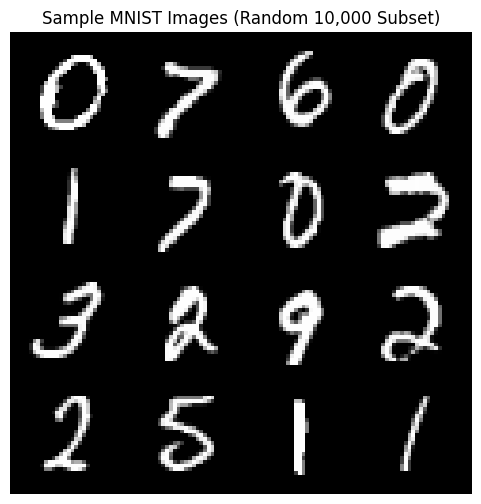

In [5]:
#Let's plot some to make sure
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize images: [-1, 1] → [0, 1]
images = images * 0.5 + 0.5

# Create a grid of the first 16 images
grid_img = vutils.make_grid(images[:16], nrow=4, padding=2)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.axis("off")
plt.title("Sample MNIST Images (Random 10,000 Subset)")
plt.show()


Let's learn the flow via CFM:

In [6]:
#################################
#            OT-CFM
#################################


n_epochs = 20

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device) #for MNIST
#model = UNetModel(dim=(1, 32, 32), num_channels=32, num_res_blocks=1).to(device) #for CIFAR-10
optimizer = torch.optim.Adam(model.parameters())
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [7]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

0it [00:00, ?it/s]

468it [00:28, 16.64it/s]
468it [00:28, 16.45it/s]
468it [00:27, 16.85it/s]
468it [00:28, 16.66it/s]
468it [00:27, 16.82it/s]
468it [00:28, 16.62it/s]
468it [00:27, 16.97it/s]
468it [00:27, 17.03it/s]
468it [00:27, 16.96it/s]
468it [00:28, 16.71it/s]
468it [00:27, 16.78it/s]
468it [00:27, 16.79it/s]
468it [00:27, 16.77it/s]
468it [00:28, 16.71it/s]
468it [00:28, 16.58it/s]
468it [00:27, 16.91it/s]
468it [00:28, 16.49it/s]
468it [00:27, 16.75it/s]
468it [00:28, 16.58it/s]
468it [00:27, 16.80it/s]


In [ ]:
#torch.save(model.state_dict(), "/home/turan/koopman/cfm_model/unet_model_mnist.pth")

In [7]:
model.load_state_dict(torch.load("/home/turan/koopman/cfm_model/unet_model_mnist.pth"))
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [8]:
dynamics = UNetModelWrapperKoopman(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to("cpu")
dynamics.load_state_dict(torch.load("/home/turan/koopman/cfm_model/unet_model_mnist.pth"))

<All keys matched successfully>

In [9]:
for p in dynamics.parameters():
    p.requires_grad = False

In [10]:
from time import time

Sampling time: 5.345369338989258


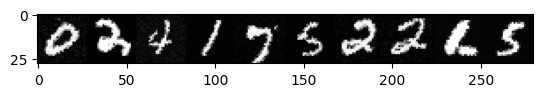

In [11]:
#Check that the learned flow generates ok samples
with torch.no_grad():
    top = time()
    traj = node.trajectory(
        torch.randn(10, 1, 28, 28, device=device),
        t_span=torch.linspace(0, 1, 100, device=device),
    )
    print(f'Sampling time: {(time()-top)}')
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)


# Koopman

In [21]:
class UNetModel_encoder(nn.Module):
    """The full UNet model with attention and timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(conv_nd(dims, in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, input_ch, out_channels, 3, padding=1)),
        )

    def convert_to_fp16(self):
        """Convert the torso of the model to float16."""
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """Convert the torso of the model to float32."""
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, inputs, y=None):
        """Apply the model to an input batch.

        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        x = inputs[:,1:].reshape((-1, 1, 28, 28))
        timesteps = inputs[:,0]
        
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        while timesteps.dim() > 1:
            #print(timesteps.shape)
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        h = self.out(h)
        #h = h.reshape(inputs[:,1:].shape)
        #print(h)
        return torch.hstack((inputs, h))


class UNetModelWrapper_encoder(UNetModel_encoder):
    def __init__(
        self,
        dim,
        num_channels,
        num_res_blocks,
        channel_mult=None,
        learn_sigma=False,
        class_cond=False,
        num_classes=NUM_CLASSES,
        use_checkpoint=False,
        attention_resolutions="16",
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        dropout=0,
        resblock_updown=False,
        use_fp16=False,
        use_new_attention_order=False,
    ):
        """Dim (tuple): (C, H, W)"""
        image_size = dim[-1]
        if channel_mult is None:
            if image_size == 512:
                channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
            elif image_size == 256:
                channel_mult = (1, 1, 2, 2, 4, 4)
            elif image_size == 128:
                channel_mult = (1, 1, 2, 3, 4)
            elif image_size == 64:
                channel_mult = (1, 2, 3, 4)
            elif image_size == 32:
                channel_mult = (1, 2, 2, 2)
            elif image_size == 28:
                channel_mult = (1, 2, 2)
            else:
                raise ValueError(f"unsupported image size: {image_size}")
        else:
            channel_mult = list(channel_mult)

        attention_ds = []
        for res in attention_resolutions.split(","):
            attention_ds.append(image_size // int(res))

        return super().__init__(
            image_size=image_size,
            in_channels=dim[0],
            model_channels=num_channels,
            out_channels=(dim[0] if not learn_sigma else dim[0] * 2),
            num_res_blocks=num_res_blocks,
            attention_resolutions=tuple(attention_ds),
            dropout=dropout,
            channel_mult=channel_mult,
            num_classes=(num_classes if class_cond else None),
            use_checkpoint=use_checkpoint,
            use_fp16=use_fp16,
            num_heads=num_heads,
            num_head_channels=num_head_channels,
            num_heads_upsample=num_heads_upsample,
            use_scale_shift_norm=use_scale_shift_norm,
            resblock_updown=resblock_updown,
            use_new_attention_order=use_new_attention_order,
        )

    def forward(self, inputs, y=None, *args, **kwargs):
        return super().forward(inputs, y=y)


class Decoder(nn.Module):
    def __init__(self, dim=(1, 28, 28)):
        super().__init__()
        self.input_dimension = dim[-1]*dim[-2]+1
    
    def forward(self, tensor2d_x):
        return tensor2d_x[:,:self.input_dimension]

class Autoencoder_unet(nn.Module):
    def __init__(self, num_channels,num_res_blocks, dim):
        super().__init__()
        self.encoder = UNetModelWrapper_encoder(dim=dim, num_channels=num_channels, num_res_blocks=num_res_blocks).to(device)
        self.decoder = Decoder(dim)
        

    def forward(self, tensor2d_x: torch.Tensor):
        tensor2d_x = self.encoder(tensor2d_x)
        return self.decoder(tensor2d_x)

In [22]:
pip install torchmetrics[image]

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install torch-fidelity

Note: you may need to restart the kernel to use updated packages.


# Ablation friendly code for ablations

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher
from torchcfm.models.unet import UNetModel
from tqdm import tqdm
import math
import sys
from contextlib import redirect_stdout
import io
import traceback
from time import time
import glob

# FID computation imports
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    FID_AVAILABLE = True
    print("DEBUG: FID_AVAILABLE = True")
except ImportError as e:
    print(f"Warning: torchmetrics import failed: {e}")
    FID_AVAILABLE = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained CFM model, it's trained further above 
def load_pretrained_cfm():
    cfm_model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
    cfm_model.load_state_dict(torch.load("/home/turan/koopman/cfm_model/unet_model_mnist.pth"))
    cfm_model.eval()
    return cfm_model


# Function to get real samples from baseline
def get_real_samples_from_baseline(baseline_path='cfm_baseline_results.pth', n_samples=1000):
    """Load real samples from the baseline computation"""
    try:
        if os.path.exists(baseline_path):
            print(f"Loading real samples from baseline file: {baseline_path}")
            baseline_data = torch.load(baseline_path)
            real_samples = baseline_data['real_samples'][:n_samples]
            print(f"Loaded {real_samples.shape[0]} real samples from baseline")
            return real_samples
        else:
            print(f"Baseline file not found: {baseline_path}")
            return None
    except Exception as e:
        print(f"Error loading baseline samples: {e}")
        return None

def get_latest_checkpoint(embedding_dim, max_epoch=None):
    """Find the latest checkpoint for a given embedding dimension"""
    # Look for checkpoints with this embedding dimension
    pattern = f"koopman_model_dim_{embedding_dim}_epoch_*.pth"
    checkpoints = glob.glob(pattern)
    
    if not checkpoints:
        return None
    
    # Extract epoch numbers and find the latest
    epochs = []
    for checkpoint in checkpoints:
        try:
            epoch = int(checkpoint.split('_epoch_')[1].split('.pth')[0])
            if max_epoch is None or epoch <= max_epoch:
                epochs.append((epoch, checkpoint))
        except:
            continue
    
    if not epochs:
        return None
    
    # Return the checkpoint with highest epoch number
    epochs.sort(key=lambda x: x[0])
    return epochs[-1][1]

# Function to generate and save x0, x1 pairs using CFM trajectories
def generate_cfm_pairs(cfm_model, n_pairs=10000, batch_size=200, save_path='cfm_pairs.pth'):
    """Generate n_pairs of (x0, x1) using CFM trajectories and save them"""
    from torchdyn.core import NeuralODE
    
    print(f"Generating {n_pairs} CFM pairs using trajectory method...")
    
    # Create NeuralODE for trajectory generation
    node = NeuralODE(cfm_model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    
    x0_list = []
    x1_list = []
    collected = 0
    
    with torch.no_grad():
        while collected < n_pairs:
            # Calculate how many samples to generate in this batch
            samples_needed = min(batch_size, n_pairs - collected)
            
            print(f"Generating batch: {collected + 1} to {collected + samples_needed} of {n_pairs}")
            
            # Generate initial noise
            x0_batch = torch.randn(samples_needed, 1, 28, 28, device=device)
            
            # Generate trajectory from t=0 to t=1 using the underlying CFM
            top = time()
            traj = node.trajectory(
                x0_batch,
                t_span=torch.linspace(0, 1, 100, device=device),
            )
            print(f'Trajectory sampling time: {(time()-top):.2f}s')
            
            # Extract x0 (initial) and x1 (final) states
            x0_final = traj[0]  # t=0
            x1_final = traj[-1]  # t=1
            
            x0_list.append(x0_final.cpu())
            x1_list.append(x1_final.cpu())
            
            collected += samples_needed
            
            # Free GPU memory
            del traj, x0_batch
            torch.cuda.empty_cache()
    
    # Concatenate all pairs
    x0_all = torch.cat(x0_list, dim=0)
    x1_all = torch.cat(x1_list, dim=0)
    
    # Save pairs
    torch.save({
        'x0': x0_all,
        'x1': x1_all,
        'n_pairs': n_pairs
    }, save_path)
    
    print(f"Saved {n_pairs} CFM pairs to {save_path}")
    print(f"x0 shape: {x0_all.shape}, x1 shape: {x1_all.shape}")
    return x0_all, x1_all

# Function to load saved pairs
def load_cfm_pairs(load_path='cfm_pairs.pth'):
    """Load saved CFM pairs"""
    if os.path.exists(load_path):
        data = torch.load(load_path)
        print(f"Loaded {data['n_pairs']} CFM pairs from {load_path}")
        return data['x0'], data['x1']
    else:
        print(f"No saved pairs found at {load_path}")
        return None, None

# Dataset class for CFM pairs
class CFMPairsDataset(torch.utils.data.Dataset):
    def __init__(self, x0, x1):
        self.x0 = x0
        self.x1 = x1
        
    def __len__(self):
        return len(self.x0)
    
    def __getitem__(self, idx):
        return self.x0[idx], self.x1[idx]

# Decoder - extracts image part from [t, x, W*g(x)]
class Decoder(nn.Module):
    def __init__(self, dim=(1, 28, 28)):
        super().__init__()
        self.input_dimension = dim[-1]*dim[-2]+1  # 784 + 1 for time
        
    def forward(self, tensor2d_x):
        return tensor2d_x[:, :self.input_dimension]

class ConcatenatingUNetEncoder(nn.Module):
    def __init__(self, num_channels=32, num_res_blocks=1, dim=(1, 28, 28), embedding_dim=1569):
        super().__init__()
        self.base_unet = UNetModel(dim=dim, num_channels=num_channels, num_res_blocks=num_res_blocks)
        self.input_dim = dim[0] * dim[1] * dim[2] + 1  # 784 + 1 for time
        
        # Calculate UNet output dimension
        unet_output_dim = dim[0] * dim[1] * dim[2]  # 784 for MNIST
        
        # Learnable projection for UNet features only so that we can control the embedding dimension
        self.embedding_dim = embedding_dim
        
        # Validate embedding dimension, must be higher than the input data dimension :) 
        if embedding_dim < self.input_dim:
            raise ValueError(f"embedding_dim ({embedding_dim}) must be >= input_dim ({self.input_dim})")
        
        # Only create projection if we need UNet features
        self.projected_unet_dim = embedding_dim - self.input_dim
        if self.projected_unet_dim > 0:
            self.unet_projection = nn.Linear(unet_output_dim, self.projected_unet_dim)
            # Initialize projection weights
            nn.init.xavier_uniform_(self.unet_projection.weight)
            nn.init.zeros_(self.unet_projection.bias)
        else:
            self.unet_projection = None
        
    def forward(self, t, x):
        # Keep input unchanged: [t, x]
        t_flat = t.expand(x.shape[0], 1) if t.dim() == 1 else t
        x_flat = x.reshape(x.shape[0], -1)
        input_concat = torch.cat([t_flat, x_flat], dim=1)  # [t, x] - unchanged
        
        if self.unet_projection is not None:
            # I had weird prints coming out, this suppresses them. 
            with redirect_stdout(io.StringIO()):
                unet_out = self.base_unet(t, x)
            
            # Project UNet features: g(x) -> W*g(x)
            unet_flat = unet_out.reshape(unet_out.shape[0], -1)
            projected_unet = self.unet_projection(unet_flat)  # W*g(x)
            
            # Final output: [t, x, W*g(x)]
            embedded = torch.cat([input_concat, projected_unet], dim=1)
        else:
            # Only [t, x], no UNet features
            embedded = input_concat
        
        return embedded

# Autoencoder using concatenating UNet encoder with learnable projection
class Autoencoder_unet(nn.Module):
    def __init__(self, num_channels, num_res_blocks, dim, embedding_dim):
        super().__init__()
        self.encoder = ConcatenatingUNetEncoder(num_channels, num_res_blocks, dim, embedding_dim).to(device)
        self.decoder = Decoder(dim)
        
    def forward(self, tensor2d_x: torch.Tensor):
        # Split input back to t and x for encoder
        t = tensor2d_x[:, :1]
        x = tensor2d_x[:, 1:].reshape(-1, 1, 28, 28)
        encoded = self.encoder(t, x)
        return self.decoder(encoded)

# Koopman Generator (Lie operator)
class KoopmanGenerator(nn.Module):
    def __init__(self, operator_dim):
        super().__init__()
        self.operator_dim = operator_dim
        self.L = nn.Parameter(torch.zeros(operator_dim, operator_dim))
        nn.init.normal_(self.L, mean=0.0, std=1e-3)
        
    def forward(self, g_tilde):
        return g_tilde @ self.L

# Combined Koopman-CFM Model with controllable embedding dimension
class KoopmanCFM(nn.Module):
    def __init__(self, num_channels=32, num_res_blocks=1, dim=(1, 28, 28), embedding_dim=1569):
        super().__init__()
        self.autoencoder = Autoencoder_unet(num_channels, num_res_blocks, dim, embedding_dim)
        self.generator = KoopmanGenerator(embedding_dim)  # Can control the embedding dimension of operator
        self.input_dim = dim[-1] * dim[-2] + 1  # 784 + 1 for time
        self.embedding_dim = embedding_dim
        
    def forward(self, x_t):
        g_tilde = self.autoencoder.encoder(x_t)  # UNet concatenates and projects features
        L_g = self.generator(g_tilde)
        return g_tilde, L_g
    
    def decode(self, g_tilde):
        # Use the decoder to extract image part
        return self.autoencoder.decoder(g_tilde)

def compute_fid(real_samples, generated_samples):
    """
    Computes the Frechet Inception Distance (FID) between two sets of images.
    """
    if not FID_AVAILABLE:
        print("torchmetrics is not available. Skipping FID computation.")
        return float('nan') # Return Not a Number if library is missing

    print("DEBUG: Initializing FID metric...")
    fid = FrechetInceptionDistance().to(device)

    def prepare_samples(samples):
        """Prepares samples for FID computation: move to device, scale, and ensure 3 channels."""
        
        samples = samples.to(device)
        print(f"DEBUG: Input samples range: [{samples.min():.3f}, {samples.max():.3f}]")
        
        # Clamp, scale to [0, 255] and convert to uint8
        
        prepared = ((samples.clamp(-1, 1) + 1) / 2 * 255).to(torch.uint8)
        
        
        if prepared.shape[1] == 1:
            prepared = prepared.repeat(1, 3, 1, 1)
            
        print(f"DEBUG: Prepared samples shape: {prepared.shape}, dtype: {prepared.dtype}")
        return prepared

    try:
        # Prepare both real and generated samples
        real_prepared = prepare_samples(real_samples)
        generated_prepared = prepare_samples(generated_samples)
        
        # Update the metric with batches of images
        print("DEBUG: Updating FID with real samples...")
        fid.update(real_prepared, real=True)
        print("DEBUG: Updating FID with generated samples...")
        fid.update(generated_prepared, real=False)
        
        # Compute and return the final score
        return fid.compute().item()

    except Exception as e:
        # Catch potential errors during computation, like the device mismatch
        print(f"DEBUG: FID computation error: {e}")
        traceback.print_exc() # Print the full traceback for detailed debugging
        return None # Return None on error

# Function to compute target FID from CFM baseline
def compute_target_fid():
    """Compute or load CFM baseline FID as target"""
    baseline_path = 'cfm_baseline_results.pth'
    
    # Try to load existing baseline
    if os.path.exists(baseline_path):
        try:
            baseline_data = torch.load(baseline_path)
            target_fid = baseline_data.get('fid_score', None)
            if target_fid is not None:
                print(f"Loaded target FID from baseline: {target_fid:.2f}")
                return target_fid
        except Exception as e:
            print(f"Error loading baseline: {e}")
    
    # Compute baseline if not available
    print("Computing CFM baseline FID...")
    try:
        # Load CFM model
        cfm_model = load_pretrained_cfm()
        
        # Sample from CFM using trajectories
        from torchdyn.core import NeuralODE
        node = NeuralODE(cfm_model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        
        n_samples = 1000
        batch_size = 100
        all_samples = []
        
        print("Generating CFM samples for baseline FID...")
        with torch.no_grad():
            for i in tqdm(range((n_samples + batch_size - 1) // batch_size), desc="CFM sampling"):
                current_batch_size = min(batch_size, n_samples - i * batch_size)
                x0 = torch.randn(current_batch_size, 1, 28, 28, device=device)
                
                traj = node.trajectory(x0, t_span=torch.linspace(0, 1, 100, device=device))
                all_samples.append(traj[-1].cpu()) 
                
                del traj, x0
                torch.cuda.empty_cache()
        
        cfm_samples = torch.cat(all_samples, dim=0)[:n_samples]
        
        # Get real samples
        print("Loading real MNIST samples...")
        trainset = datasets.MNIST("../data", train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5,), (0.5,))
                                ]))
        train_loader = DataLoader(trainset, batch_size=100, shuffle=True)
        
        real_samples = []
        total_collected = 0
        for batch, _ in train_loader:
            real_samples.append(batch)
            total_collected += batch.shape[0]
            if total_collected >= n_samples:
                break
        
        real_samples = torch.cat(real_samples, dim=0)[:n_samples]
        
        print(f"DEBUG: Real samples shape: {real_samples.shape}, Generated samples shape: {cfm_samples.shape}")

        # Compute FID
        if FID_AVAILABLE:
            target_fid = compute_fid(real_samples, cfm_samples)
            
            if target_fid is None:
                print("FID computation failed. Using fallback value.")
                return 27.75

            # Save for future use
            torch.save({
                'real_samples': real_samples,
                'cfm_samples': cfm_samples,
                'fid_score': target_fid,
                'n_samples': n_samples
            }, baseline_path)
            
            print(f"Computed and saved target FID: {target_fid:.2f}")
            return target_fid
        else:
            print("FID computation not available using default target")
            return 27.75
            
    except Exception as e:
        print(f"Error computing CFM baseline: {e}")
        traceback.print_exc() 
        return 27.75  # Fallback to a value I computed on the CFM model trained above


# Sampling function
def sample_koopman(model, n_samples=16, n_steps=100):
    model.eval()
    with torch.no_grad():
        # Initial noise
        x0 = torch.randn(n_samples, 28, 28).to(device)
        t0 = torch.zeros(n_samples, 1).to(device)
        
        # Encode initial state, encoder expects separate t and x arguments
        g0 = model.autoencoder.encoder(t0, x0.reshape(n_samples, 1, 28, 28))
        
        # Matrix exponentiation for t=1
        L_matrix = model.generator.L
        exp_L = torch.matrix_exp(L_matrix)
        
        # Evolve in Koopman space
        g1 = g0 @ exp_L
        
        # Decode to get final state
        x1_decoded = model.decode(g1)
        
        # Extract images (removes the time dimension)
        x1_images = x1_decoded[:, 1:].reshape(n_samples, 1, 28, 28)
        
        return x1_images

# Training function with simple boolean ablation controls + embedding dimension ablation
def train_koopman_cfm(
    # Simple loss ablation flags
    consistency_loss_on=True,
    target_loss_on=True, 
    target_phase_loss_on=True,
    
    # Loss weights 
    consistency_weight=1.0,
    target_weight=1.0,
    target_phase_weight=1.0,
    
    # Embedding dimension ablation
    embedding_dim=1569,  
    # Standard training params
    n_epochs=100,
    batch_size=128,
    lr=3e-4,
    fid_n_samples=1000,
    n_cfm_pairs=100000, #They use 250K-1M samples in Omri's paper 
    pairs_batch_size=64
):
    """
    Training function with embedding dimension ablation
    
    Args:
        consistency_loss_on: Enable Koopman consistency loss
        target_loss_on: Enable decoded endpoint matching loss
        target_phase_loss_on: Enable phase space matching loss
        *_weight: Loss weights (only used if loss is enabled)
        embedding_dim: Koopman embedding dimension (ablation parameter)
    """
    
    # Training configuration
    print("=" * 80)
    print("KOOPMAN-CFM TRAINING CONFIGURATION")
    print("=" * 80)
    print(f"  Consistency Loss: {consistency_loss_on}")
    print(f"  Target Loss: {target_loss_on}")  
    print(f"  Target Phase Loss: {target_phase_loss_on}")
    print(f"  Embedding Dimension: {embedding_dim}")
    
    # Compute target FID
    target_fid = compute_target_fid()
    print(f"  Target FID: {target_fid:.2f}")
    print("=" * 80)
    
    # Validate at least one loss is on
    if not any([consistency_loss_on, target_loss_on, target_phase_loss_on]):
        raise ValueError("At least one loss must be enabled!")
    
    # Validate embedding dimension
    if embedding_dim < 785:
        raise ValueError("Embedding dimension must be >= 785 (input dimension)")
    
    # Load data
    trainset = datasets.MNIST(
        "../data", train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.5,), (0.5,))
        ])
    )
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    # Load pre-trained CFM
    cfm_model = load_pretrained_cfm()
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)
    
    # Only load CFM pairs if target losses are enabled
    pairs_loader = None
    if target_loss_on or target_phase_loss_on:
        pairs_path = 'cfm_pairs.pth'
        x0_pairs, x1_pairs = load_cfm_pairs(pairs_path)
        
        if x0_pairs is None:
            print("Generating new CFM pairs...")
            x0_pairs, x1_pairs = generate_cfm_pairs(cfm_model, n_cfm_pairs, batch_size=200, save_path=pairs_path)
        
        pairs_dataset = CFMPairsDataset(x0_pairs, x1_pairs)
        pairs_loader = DataLoader(pairs_dataset, batch_size=pairs_batch_size, shuffle=True, drop_last=True)
    
    # Get real samples for FID
    real_samples_fid = None
    if FID_AVAILABLE:
        real_samples_fid = get_real_samples_from_baseline('cfm_baseline_results.pth', fid_n_samples)
        if real_samples_fid is not None:
            real_samples_fid = real_samples_fid.to(device)
    
    # Initialize model with controllable embedding dimension
    koopman_model = KoopmanCFM(
        num_channels=32, 
        num_res_blocks=1, 
        dim=(1, 28, 28), 
        embedding_dim=embedding_dim  # Key parameter for the embedding dimension ablation
    ).to(device)
    
    # Print model info (in Omri's paper they have plot of FID vs model capacity)
    total_params = sum(p.numel() for p in koopman_model.parameters())
    trainable_params = sum(p.numel() for p in koopman_model.parameters() if p.requires_grad)
    koopman_params = koopman_model.generator.L.numel()  # embedding_dim x embedding_dim
    
    print(f"Model Parameters:")
    print(f"  Total: {total_params:,}")
    print(f"  Trainable: {trainable_params:,}")
    print(f"  Koopman Operator (L): {koopman_params:,} ({embedding_dim}x{embedding_dim})")
    if embedding_dim > 785:
        projection_params = 784 * (embedding_dim - 785) + (embedding_dim - 785)
        print(f"  Projection Parameters: {projection_params:,}")
    
    optimizer = optim.Adam(koopman_model.parameters(), lr=lr)
    #In omri's paper they use constant learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.8)
    
    fid_scores = []
    
    # Training loop
    for epoch in range(n_epochs):
        koopman_model.train()
        epoch_loss = 0
        epoch_consistency = 0
        epoch_target = 0  
        epoch_target_phase = 0
        
        # Generate samples and compute FID
        if epoch == 0 or epoch % 1 == 0:  # Report FID every epoch
            samples = sample_koopman(koopman_model, n_samples=16)
            
            # Compute FID
            fid_score = None
            if FID_AVAILABLE and real_samples_fid is not None:
                try:
                    fid_samples = sample_koopman(koopman_model, n_samples=fid_n_samples)
                    fid_score = compute_fid(real_samples_fid, fid_samples)
                    if fid_score is not None:
                        fid_scores.append(fid_score)
                        print(f"FID Score: {fid_score:.2f} (Target: {target_fid:.2f}) [Dim: {embedding_dim}]")
                except Exception as e:
                    print(f"FID failed: {e}")
            
            # Plot samples
            samples_display = torch.clamp(samples * 0.5 + 0.5, 0, 1)
            grid = make_grid(samples_display, nrow=4, padding=2, normalize=False)
            
            plt.figure(figsize=(8, 8))
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            title = f'Epoch {epoch} - Embedding Dim: {embedding_dim}'
            if fid_score is not None:
                title += f'\nFID: {fid_score:.2f}'
            plt.title(title)
            plt.tight_layout()
            
            os.makedirs(f'koopman_samples_dim_{embedding_dim}', exist_ok=True)
            plt.savefig(f'koopman_samples_dim_{embedding_dim}/epoch_{epoch}.png', dpi=150, bbox_inches='tight')
            plt.show()
        
        # Setup pairs iterator if needed
        if pairs_loader is not None:
            pairs_iter = iter(pairs_loader)
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Dim: {embedding_dim}]')
        for batch_idx, (x1, _) in enumerate(pbar):
            x1 = x1.to(device)
            optimizer.zero_grad()
            
            total_loss = 0
            consistency_loss = 0
            target_loss = 0
            target_phase_loss = 0
            
            # Consistency Loss
            if consistency_loss_on:
                x0 = torch.randn_like(x1)
                t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1) #Simulation free, we exploit the derived result (FM comes from the CFM)
                
                with torch.no_grad():
                    vt = cfm_model(t, xt)
                
                if t.dim() == 1:
                    t = t.unsqueeze(1)
                
                g_tilde = koopman_model.autoencoder.encoder(t, xt)
                L_g = koopman_model.generator(g_tilde)
                
                def encoder_func(t_input, x_input):
                    return koopman_model.autoencoder.encoder(t_input, x_input)
                
                v_t_component = torch.ones_like(t)
                v_x_component = vt
                
                jvp_result = autograd.functional.jvp(
                    encoder_func, 
                    (t, xt), 
                    (v_t_component, v_x_component),
                    create_graph=True
                )[1]
                
                consistency_loss = nn.MSELoss()(L_g, jvp_result)
                total_loss += consistency_weight * consistency_loss
                epoch_consistency += consistency_loss.item()
            
            # Target Losses
            if target_loss_on or target_phase_loss_on:
                try:
                    x0_pair, x1_pair = next(pairs_iter)
                except StopIteration:
                    pairs_iter = iter(pairs_loader)
                    x0_pair, x1_pair = next(pairs_iter)
                
                x0_pair = x0_pair.to(device)
                x1_pair = x1_pair.to(device)
                
                t_zero = torch.zeros(x0_pair.shape[0], 1).to(device)
                t_one = torch.ones(x1_pair.shape[0], 1).to(device)
                
                g_x0 = koopman_model.autoencoder.encoder(t_zero, x0_pair)
                g_x1 = koopman_model.autoencoder.encoder(t_one, x1_pair)
                
                L_exp = torch.matrix_exp(koopman_model.generator.L)
                evolved_g_x0 = g_x0 @ L_exp
                
                if target_loss_on:
                    decoded_evolved = koopman_model.decode(evolved_g_x0)
                    decoded_target = koopman_model.decode(g_x1)
                    target_loss = nn.MSELoss()(decoded_evolved, decoded_target)
                    total_loss += target_weight * target_loss
                    epoch_target += target_loss.item()
                
                if target_phase_loss_on:
                    target_phase_loss = nn.MSELoss()(evolved_g_x0, g_x1)
                    total_loss += target_phase_weight * target_phase_loss
                    epoch_target_phase += target_phase_loss.item()
            
            # Backward pass
            if total_loss > 0:
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(koopman_model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += total_loss.item()
            
            # Progress bar
            pbar_dict = {'Loss': f'{total_loss.item():.6f}', 'Dim': str(embedding_dim)}
            if consistency_loss_on:
                pbar_dict['Consist'] = f'{consistency_loss.item():.6f}'
            if target_loss_on:
                pbar_dict['Target'] = f'{target_loss.item():.6f}'
            if target_phase_loss_on:
                pbar_dict['Phase'] = f'{target_phase_loss.item():.6f}'
            if fid_score is not None:
                pbar_dict['FID'] = f'{fid_score:.2f}'
            
            pbar.set_postfix(pbar_dict)
        
        # Epoch summary
        avg_loss = epoch_loss / len(train_loader)
        scheduler.step(avg_loss)
        
        summary = [f'Epoch {epoch+1}', f'Dim: {embedding_dim}', f'Loss: {avg_loss:.6f}']
        
        if consistency_loss_on:
            summary.append(f'Consist: {epoch_consistency/len(train_loader):.6f}')
        if target_loss_on:
            summary.append(f'Target: {epoch_target/len(train_loader):.6f}')
        if target_phase_loss_on:
            summary.append(f'Phase: {epoch_target_phase/len(train_loader):.6f}')
        if fid_score is not None:
            summary.append(f'FID: {fid_score:.2f}')
            if fid_score <= target_fid:
                summary.append('TARGET!')
        
        print(' | '.join(summary))
        
        # Save checkpoint with dimension and eopch info
        checkpoint_name = f'koopman_model_dim_{embedding_dim}_epoch_{epoch+1}.pth'
        torch.save({
            'model_state_dict': koopman_model.state_dict(),
            'embedding_dim': embedding_dim,
            'epoch': epoch + 1,
            'fid_scores': fid_scores,
            'target_fid': target_fid,
            'config': {
                'consistency_loss_on': consistency_loss_on,
                'target_loss_on': target_loss_on,
                'target_phase_loss_on': target_phase_loss_on,
                'embedding_dim': embedding_dim,
                'target_fid': target_fid
            }
        }, checkpoint_name)
    
    # Final FID summary, plot of FID vs epochs
    if len(fid_scores) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(range(0, len(fid_scores)*5, 5), fid_scores, 'b-', linewidth=2, marker='o')
        plt.axhline(y=target_fid, color='r', linestyle='--', label=f'Target FID ({target_fid:.2f})')
        plt.xlabel('Epoch')
        plt.ylabel('FID Score')
        plt.title(f'FID Evolution - Embedding Dim: {embedding_dim}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'koopman_samples_dim_{embedding_dim}/fid_evolution.png', dpi=150)
        plt.show()
        
        final_fid = fid_scores[-1]
        best_fid = min(fid_scores)
        
        print(f"Final FID: {final_fid:.2f}")
        print(f"Best FID: {best_fid:.2f}")
        print(f"Target FID: {target_fid:.2f}")
        print(f"Embedding Dimension: {embedding_dim}")
    
    return koopman_model

def test_sampling(model_path=None, embedding_dim=None):
    """Test final sampling"""
    
    # If no model path provided, find the latest checkpoint
    if model_path is None:
        if embedding_dim is not None:
            model_path = get_latest_checkpoint(embedding_dim)
            if model_path is None:
                print(f"No checkpoints found for embedding_dim={embedding_dim}")
                return
        else:
            # Find any recent checkpoint
            dim_checkpoints = glob.glob("koopman_model_dim_*_epoch_*.pth")
            if dim_checkpoints:
                # Sort by modification time, get latest
                dim_checkpoints.sort(key=os.path.getmtime, reverse=True)
                model_path = dim_checkpoints[0]
                print(f"Using latest checkpoint: {model_path}")
            else:
                print("No checkpoints with embedding dimension found")
                return
    
    # Check if file exists
    if not os.path.exists(model_path):
        print(f"Checkpoint not found: {model_path}")
        
        # Suggest other checkpoints
        print("Available checkpoints:")
        checkpoints = glob.glob("koopman_model_dim_*_epoch_*.pth")
        if checkpoints:
            checkpoints.sort(key=os.path.getmtime, reverse=True)
            for i, cp in enumerate(checkpoints[:5]):  # Show latest 
                print(f"  {i+1}. {cp}")
        else:
            print("  No checkpoints found")
            
        return
    
    # Load checkpoint
    try:
        checkpoint = torch.load(model_path)
        print(f"Loading checkpoint: {model_path}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return
    
    # Get embedding dimension from checkpoint or parameter
    if embedding_dim is None:
        embedding_dim = checkpoint.get('embedding_dim', 1569)  # Defaults back to the setting without the projection matrix
    
    print(f"Model configuration:")
    print(f"  Embedding dimension: {embedding_dim}")
    if 'config' in checkpoint:
        config = checkpoint['config']
        print(f"  Consistency Loss: {config.get('consistency_loss_on', 'Unknown')}")
        print(f"  Target Loss: {config.get('target_loss_on', 'Unknown')}")
        print(f"  Target Phase Loss: {config.get('target_phase_loss_on', 'Unknown')}")
        if 'target_fid' in config:
            print(f"  Target FID: {config['target_fid']:.2f}")
        print(f"  Epoch: {checkpoint.get('epoch', 'Unknown')}")
    
    # Initialize model
    koopman_model = KoopmanCFM(
        num_channels=32,
        num_res_blocks=1,
        dim=(1, 28, 28),
        embedding_dim=embedding_dim
    ).to(device)
    
    # Load state dict
    try:
        koopman_model.load_state_dict(checkpoint['model_state_dict'])
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model state: {e}")
        return
    
    # Generate samples
    print("Generating samples...")
    samples = sample_koopman(koopman_model, n_samples=64)
    samples = samples * 0.5 + 0.5
    grid = make_grid(samples, nrow=8, padding=2, normalize=False)
    
    # Plot
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
    
    # Title with key info
    title = f'Generated Samples - Embedding Dim: {embedding_dim}'
    if 'config' in checkpoint and 'target_fid' in checkpoint['config']:
        target_fid = checkpoint['config']['target_fid']
        title += f'\nTarget FID: {target_fid:.2f}'
    
    plt.title(title)
    plt.tight_layout()
    
    # Save with dimension in filename
    save_path = f'final_koopman_samples_dim_{embedding_dim}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Samples saved to: {save_path}")
    plt.show()


    
print("Koopman-CFM Training with Loss and Embedding Dimension Ablation")
    
model = train_koopman_cfm(
        # Loss ablation
        consistency_loss_on=True,
        target_loss_on=True,
        target_phase_loss_on=True,
        
        # Dimension ablation  
        embedding_dim=1765, 
        
        # Training settings
        n_epochs=2,  #Just to see if everything was working 
        batch_size=128,
        lr=3e-4 #Learning rate used by Omri
    )
    
# Test the trained model (will automatically find the right checkpoint)
test_sampling(embedding_dim=1765)


DEBUG: FID_AVAILABLE = True
Using device: cuda
Koopman-CFM Training with Loss and Embedding Dimension Ablation
KOOPMAN-CFM TRAINING CONFIGURATION
  Consistency Loss: True
  Target Loss: True
  Target Phase Loss: True
  Embedding Dimension: 1765
Loaded target FID from baseline: 28.92
  Target FID: 28.92
No saved pairs found at cfm_pairs.pth
Generating new CFM pairs...
Generating 100000 CFM pairs using trajectory method...
Generating batch: 1 to 200 of 100000
Trajectory sampling time: 11.36s
Generating batch: 201 to 400 of 100000


KeyboardInterrupt: 